In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from copy import deepcopy
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from tqdm import tqdm




In [7]:
# Define the feature extractor (f)
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(64 * 7 * 7, 128)

    def forward(self, x):
        x = self.conv(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

# Define the classification head (θ)
class ClassificationHead(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(ClassificationHead, self).__init__()
        self.fc = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        return self.fc(x)

# Synthesizer: A simple generator for model inversion
class Synthesizer(nn.Module):
    def __init__(self, feature_dim, image_shape):
        super(Synthesizer, self).__init__()
        self.fc = nn.Linear(feature_dim, np.prod(image_shape))
        self.image_shape = image_shape

    def forward(self, features):
        images = self.fc(features).view(-1, *self.image_shape)
        return torch.sigmoid(images)  # Generate synthetic images


In [8]:
def create_mnist_data(num_classes, task_index,csv_file="mnist.csv", image_shape=(1, 28, 28)):
    mnist_file = open(csv_file)
    df = pd.read_csv(mnist_file)

    # Determine the classes for this task
    all_classes = sorted(df['label'].unique())  # Get all unique classes
    start_class = task_index * num_classes      # Starting class for this task
    end_class = start_class + num_classes       # Ending class for this task
    valid_classes = all_classes[start_class:end_class]

    # Filter the dataset for the valid classes
    filtered_df = df[df['label'].isin(valid_classes)]

    # Separate features and labels
    X = filtered_df.drop(columns=['label']).values  # Features (flattened images)
    y = filtered_df['label'].values                # Labels

    # Normalize and reshape the images
    X = torch.tensor(X / 255.0, dtype=torch.float32)  # Normalize to [0, 1]
    X = X.view(-1, *image_shape)  # Reshape to (batch, 1, 28, 28)
    y = torch.tensor(y, dtype=torch.long)            # Convert labels to tensors

    return TensorDataset(X, y)

In [36]:
# Define Local Classification Loss
class LocalClassificationLoss(nn.Module):
    def __init__(self):
        super(LocalClassificationLoss, self).__init__()
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, predictions, targets):
        """
        Computes local classification loss (cross-entropy) on new data and new classifiers
        to adapt the model to the new task while minimizing interference with old tasks.
        """
        return self.criterion(predictions, targets)


# Define Hard Knowledge Distillation Loss
class HardKnowledgeDistillationLoss(nn.Module):
    def __init__(self, temperature=1.0):
        """
        Initializes the HKD loss with a temperature parameter.
        """
        super(HardKnowledgeDistillationLoss, self).__init__()
        self.temperature = temperature
        self.criterion = nn.KLDivLoss(reduction="batchmean")

    def forward(self, student_logits, teacher_logits):
        """
        Computes a harder variant of the HKD loss, applying it on synthetic data.
        The teacher logits are detached, and the temperature scaling is applied.
        """
        student_softmax = F.log_softmax(student_logits / self.temperature, dim=-1)
        teacher_softmax = F.softmax(teacher_logits / self.temperature, dim=-1).detach()
        return self.criterion(student_softmax, teacher_softmax) * (self.temperature ** 2)


# Define Relational Knowledge Distillation Loss
class RelationalKnowledgeDistillationLoss(nn.Module):
    def __init__(self):
        super(RelationalKnowledgeDistillationLoss, self).__init__()
        self.criterion = nn.MSELoss()

    def forward(self, student_features, teacher_features):
        """
        Computes angle-wise relational knowledge distillation loss.
        Transforms the representations before constructing relations and computes
        cosine similarity among triplets of samples.
        """
        # Compute pairwise cosine similarities for triplets
        def cosine_triplet_relations(features):
            normed_features = F.normalize(features, dim=-1)
            relations = torch.matmul(normed_features, normed_features.T)  # Cosine similarities
            return relations

        teacher_relations = cosine_triplet_relations(teacher_features.detach())
        student_relations = cosine_triplet_relations(student_features)

        # Compute MSE loss between teacher and student relations
        return self.criterion(student_relations, teacher_relations)

# Train the Synthesizer
def train_synthesizer(feature_extractor, old_model, synthesizer, train_loader, device):
    synthesizer.train()
    optimizer = optim.Adam(synthesizer.parameters(), lr=0.001)
    criterion = nn.MSELoss()

    for epoch in range(5):  # Train for 5 epochs
        for images, _ in train_loader:
            images = images.to(device)

            # Extract features from the old model
            with torch.no_grad():
                features = old_model(images)

            # Generate synthetic images
            synthetic_images = synthesizer(features)

            # Compute loss (reconstruction loss)
            loss = criterion(synthetic_images, images)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

# Elastic Weight Consolidation (EWC) Implementation
class EWC:
    def __init__(self, model, dataloader, device):
        self.device = device
        self.model = model
        self.fisher_information = {}
        self.saved_params = {}
        self.compute_fisher_information(dataloader)

    def compute_fisher_information(self, dataloader):
        self.model.eval()
        fisher_matrix = {}
        for name, param in self.model.named_parameters():
            fisher_matrix[name] = torch.zeros_like(param)
        for images, labels in dataloader:
            images, labels = images.to(self.device), labels.to(self.device)
            self.model.zero_grad()
            outputs = self.model(images)
            loss = F.cross_entropy(outputs, labels)
            loss.backward()
            for name, param in self.model.named_parameters():
                fisher_matrix[name] += param.grad ** 2
        for name, param in self.model.named_parameters():
            self.fisher_information[name] = fisher_matrix[name] / len(dataloader)

    def penalty(self):
        loss = 0.0
        for name, param in self.model.named_parameters():
            if name in self.saved_params:
                loss += torch.sum(self.fisher_information[name] * (param - self.saved_params[name]) ** 2)
        return loss

    def save_params(self):
        for name, param in self.model.named_parameters():
            self.saved_params[name] = param.clone().detach()

# Train R-DFCIL with EWC

def train_r_dfcil(task_data, num_classes_per_task, image_shape, num_epoch=3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    feature_extractor = FeatureExtractor().to(device)
    synthesizer = Synthesizer(128, image_shape).to(device)

    old_model = None
    old_classification_head = None
    ewc = None

    for task_index, (train_dataset, test_dataset) in enumerate(task_data):
        num_classes = sum(num_classes_per_task[:task_index + 1])
        classification_head = ClassificationHead(128, num_classes).to(device)
        print("num_classes:", num_classes)
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

        # Stage 1: Train Synthesizer
        if old_model is not None:
            train_synthesizer(feature_extractor, old_model, synthesizer, train_loader, device)

        # Stage 2: Representation Learning
        feature_extractor.train()
        classification_head.train()
        optimizer = optim.Adam(
            list(feature_extractor.parameters()) + list(classification_head.parameters()),
            lr=0.001,
        )

        local_loss_fn = LocalClassificationLoss()
        if old_model is not None:
            hard_kd_loss_fn = HardKnowledgeDistillationLoss()
            relational_kd_loss_fn = RelationalKnowledgeDistillationLoss()

        print(f"Training task {task_index + 1} - Representation Learning")
        for epoch in range(num_epoch):
            epoch_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epoch}", leave=False)
            for images, labels in epoch_bar:
                images, labels = images.to(device), labels.to(device)

                # Forward pass
                features = feature_extractor(images)
                predictions = classification_head(features)

                # Local classification loss
                loss = local_loss_fn(predictions, labels)

                # Knowledge distillation losses
                if old_model is not None:
                    with torch.no_grad():
                        old_features = old_model(images)
                        old_predictions = old_classification_head(old_features)

                    # Align the output shapes before calculating the loss
                    old_predictions = F.pad(old_predictions, (0, num_classes - old_predictions.shape[1]))

                    # Dynamic weighting for KD losses
                    hkd_loss = hard_kd_loss_fn(predictions, old_predictions)
                    rkd_loss = relational_kd_loss_fn(features, old_features)

                    kd_weight = 0.5  # Can be dynamically adjusted based on performance
                    loss += kd_weight * (hkd_loss + rkd_loss)

                # EWC penalty
                if ewc is not None:
                    loss += 0.01 * ewc.penalty()  # Regularization strength can be tuned

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            print(f"Epoch {epoch + 1} completed.")

        # Stage 3: Refining the Classification Head
        classification_head.train()
        class_counts = torch.zeros(num_classes, device=device)
        for _, labels in train_loader:
            for label in labels:
                class_counts[label] += 1

        class_weights = 1.0 / (class_counts + 1e-5)  # Avoid division by zero
        class_weights /= class_weights.sum()

        global_loss_fn = nn.CrossEntropyLoss(weight=class_weights)
        optimizer = optim.Adam(classification_head.parameters(), lr=0.001)

        print(f"Training task {task_index + 1} - Refining Classification Head")
        for epoch in range(5):  # Refine for 5 epochs
            epoch_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/5", leave=False)
            for images, labels in epoch_bar:
                images, labels = images.to(device), labels.to(device)

                # Forward pass
                features = feature_extractor(images)
                predictions = classification_head(features)

                # Compute global loss
                loss = global_loss_fn(predictions, labels)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            print(f"Epoch {epoch + 1} completed.")

        # Save the old model and classification head
        old_model = feature_extractor
        old_classification_head = classification_head

        # Initialize EWC for the current task
        ewc = EWC(feature_extractor, train_loader, device)
        ewc.save_params()

    return feature_extractor, classification_head, synthesizer


In [37]:
num_classes_per_task = [5, 5]  # Task 1: 5 classes, Task 2: 5 classes
image_shape = (1, 28, 28)

# Load MNIST datasets for tasks
task1_data = create_mnist_data(num_classes_per_task[0], task_index=0, image_shape=image_shape)
task2_data = create_mnist_data(num_classes_per_task[1], task_index=1, image_shape=image_shape)
data = create_mnist_data(10, task_index=0, image_shape=image_shape)

# Prepare task data
task_data = [(task1_data, task1_data), (task2_data, task2_data)]  # (train, test)

# Train R-DFCIL
feature_extractor, classification_head, synthesizer = train_r_dfcil(task_data, num_classes_per_task, image_shape=image_shape)

num_classes: 5
Training task 1 - Representation Learning


Epoch 1 completed.


Epoch 2 completed.


Epoch 3 completed.
Training task 1 - Refining Classification Head


Epoch 1 completed.


Epoch 2 completed.


Epoch 3 completed.


Epoch 4 completed.


Epoch 5 completed.
num_classes: 10
Training task 2 - Representation Learning


Epoch 1 completed.


Epoch 2 completed.


Epoch 3 completed.
Training task 2 - Refining Classification Head


Epoch 1 completed.


Epoch 2 completed.


Epoch 3 completed.


Epoch 4 completed.


Epoch 5 completed.


In [38]:
def inference_on_model(feature_extractor, classification_head, loader, num_classes):
    feature_extractor.eval()
    classification_head.eval()

    all_preds = []
    all_labels = []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    feature_extractor.to(device)
    classification_head.to(device)

    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(loader):
            images, labels = images.to(device), labels.to(device)

            # Ensure images have the correct batch and channel dimensions
            if len(images.shape) == 3:  # If shape is (batch, height, width)
                images = images.unsqueeze(1)  # Add channel dimension (batch, channels, height, width)

            # Forward pass
            features = feature_extractor(images)
            logits = classification_head(features)
            predictions = torch.argmax(logits, dim=1)

            # Collect results for evaluation
            all_preds.extend(predictions.cpu().numpy())

            # Reshape labels to match batch processing
            if labels.ndimension() == 0:  # If labels are 0-dimensional (scalar)
                labels = labels.unsqueeze(0)

            all_labels.extend(labels.cpu().numpy())

            # Occasionally display predictions
            if batch_idx % 2000 == 0:  # Adjust frequency as needed
                print(f"Batch {batch_idx} Predictions:")
                print(f"Predicted: {predictions.cpu().numpy()}")
                print(f"True:      {labels.cpu().numpy()}")

    # Compute accuracy
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"\nAccuracy: {accuracy * 100:.2f}%")

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds, labels=list(range(num_classes)))
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=list(range(num_classes)),
                yticklabels=list(range(num_classes)))
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()
    print(cm)


Batch 0 Predictions:
Predicted: [7]
True:      [1]
Batch 2000 Predictions:
Predicted: [5]
True:      [3]
Batch 4000 Predictions:
Predicted: [8]
True:      [8]
Batch 6000 Predictions:
Predicted: [7]
True:      [1]
Batch 8000 Predictions:
Predicted: [8]
True:      [8]
Batch 10000 Predictions:
Predicted: [8]
True:      [2]
Batch 12000 Predictions:
Predicted: [7]
True:      [7]
Batch 14000 Predictions:
Predicted: [6]
True:      [6]
Batch 16000 Predictions:
Predicted: [8]
True:      [1]
Batch 18000 Predictions:
Predicted: [7]
True:      [7]
Batch 20000 Predictions:
Predicted: [5]
True:      [3]
Batch 22000 Predictions:
Predicted: [7]
True:      [7]
Batch 24000 Predictions:
Predicted: [9]
True:      [4]
Batch 26000 Predictions:
Predicted: [6]
True:      [1]
Batch 28000 Predictions:
Predicted: [5]
True:      [3]
Batch 30000 Predictions:
Predicted: [5]
True:      [3]
Batch 32000 Predictions:
Predicted: [6]
True:      [6]
Batch 34000 Predictions:
Predicted: [5]
True:      [1]
Batch 36000 Predic

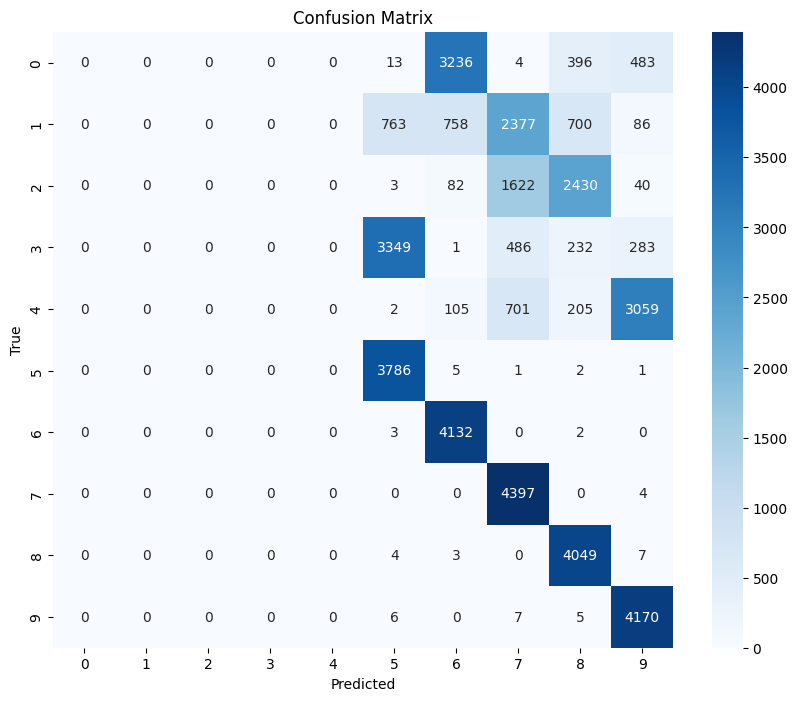

[[   0    0    0    0    0   13 3236    4  396  483]
 [   0    0    0    0    0  763  758 2377  700   86]
 [   0    0    0    0    0    3   82 1622 2430   40]
 [   0    0    0    0    0 3349    1  486  232  283]
 [   0    0    0    0    0    2  105  701  205 3059]
 [   0    0    0    0    0 3786    5    1    2    1]
 [   0    0    0    0    0    3 4132    0    2    0]
 [   0    0    0    0    0    0    0 4397    0    4]
 [   0    0    0    0    0    4    3    0 4049    7]
 [   0    0    0    0    0    6    0    7    5 4170]]


In [39]:
inference_on_model(feature_extractor,classification_head,data,10)

In [48]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

# Define a simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2, 2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2, 2)
        x = x.view(x.size(0), -1)  # Flatten
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Training function with progress bar and CUDA support
def train_model(model, data_loader, criterion, optimizer, epochs, device):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        with tqdm(total=len(data_loader), desc=f"Epoch {epoch + 1}/{epochs}", unit="batch") as pbar:
            for X_batch, y_batch in data_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                optimizer.zero_grad()
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
                pbar.set_postfix(loss=total_loss / (pbar.n + 1))
                pbar.update(1)

# Evaluation function with CUDA support
def evaluate_model(model, data_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)
    return correct / total

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Create dataloaders
batch_size = 64
task1_loader = DataLoader(task1_data, batch_size=batch_size, shuffle=True)
task2_loader = DataLoader(task2_data, batch_size=batch_size, shuffle=True)
combined_data_loader = DataLoader(data, batch_size=batch_size, shuffle=False)

# Initialize model, loss, and optimizer
num_classes = 10
model = SimpleCNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train on task 1
print("Training on Task 1...")
train_model(model, task1_loader, criterion, optimizer, epochs=5, device=device)
accuracy_task1 = evaluate_model(model, task1_loader, device)
print(f"Accuracy on Task 1: {accuracy_task1:.2f}")

# Fine-tune on task 2 with reduced learning rate
print("Fine-tuning on Task 2...")
for param_group in optimizer.param_groups:
    param_group['lr'] = 0.00001  # Reduce learning rate

train_model(model, task2_loader, criterion, optimizer, epochs=5, device=device)
accuracy_task2 = evaluate_model(model, task2_loader, device)
print(f"Accuracy on Task 2: {accuracy_task2:.2f}")

# Final evaluation on all classes
accuracy_combined = evaluate_model(model, combined_data_loader, device)
print(f"Final Accuracy on All Classes: {accuracy_combined:.2f}")


Using device: cuda
Training on Task 1...


Epoch 5/5: 100%|██████████| 335/335 [00:02<00:00, 139.36batch/s, loss=0.0121]


Accuracy on Task 1: 1.00
Fine-tuning on Task 2...


Epoch 5/5: 100%|██████████| 322/322 [00:02<00:00, 143.91batch/s, loss=0.681]


Accuracy on Task 2: 0.91
Final Accuracy on All Classes: 0.69


In [46]:
def inference_on_model(model, loader, num_classes):
    feature_extractor.eval()
    classification_head.eval()

    all_preds = []
    all_labels = []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    feature_extractor.to(device)
    classification_head.to(device)

    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(loader):
            images, labels = images.to(device), labels.to(device)

            # Ensure images have the correct batch and channel dimensions
            if len(images.shape) == 3:  # If shape is (batch, height, width)
                images = images.unsqueeze(1)  # Add channel dimension (batch, channels, height, width)

            # Forward pass
            # features = feature_extractor(images)
            logits = model(images)
            predictions = torch.argmax(logits, dim=1)

            # Collect results for evaluation
            all_preds.extend(predictions.cpu().numpy())

            # Reshape labels to match batch processing
            if labels.ndimension() == 0:  # If labels are 0-dimensional (scalar)
                labels = labels.unsqueeze(0)

            all_labels.extend(labels.cpu().numpy())

            # Occasionally display predictions
            if batch_idx % 2000 == 0:  # Adjust frequency as needed
                print(f"Batch {batch_idx} Predictions:")
                print(f"Predicted: {predictions.cpu().numpy()}")
                print(f"True:      {labels.cpu().numpy()}")

    # Compute accuracy
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"\nAccuracy: {accuracy * 100:.2f}%")

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds, labels=list(range(num_classes)))
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=list(range(num_classes)),
                yticklabels=list(range(num_classes)))
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()
    print(cm)


Batch 0 Predictions:
Predicted: [1 7 1 4 7 7 7 3 5 5 8 9 1 5 5 1 8 7 7 6 8 6 2 7 2 5 6 9 9 7 8 9 6 9 2 1 5
 1 1 4 8 1 4 9 2 6 5 7 7 4 7 5 1 9 7 2 2 3 9 1 1 1 9 7]
True:      [1 0 1 4 0 0 7 3 5 3 8 9 1 3 3 1 2 0 7 5 8 6 2 0 2 3 6 9 9 7 8 9 4 9 2 1 3
 1 1 4 9 1 4 4 2 6 3 7 7 4 7 5 1 9 0 2 2 3 9 1 1 1 5 0]

Accuracy: 68.99%


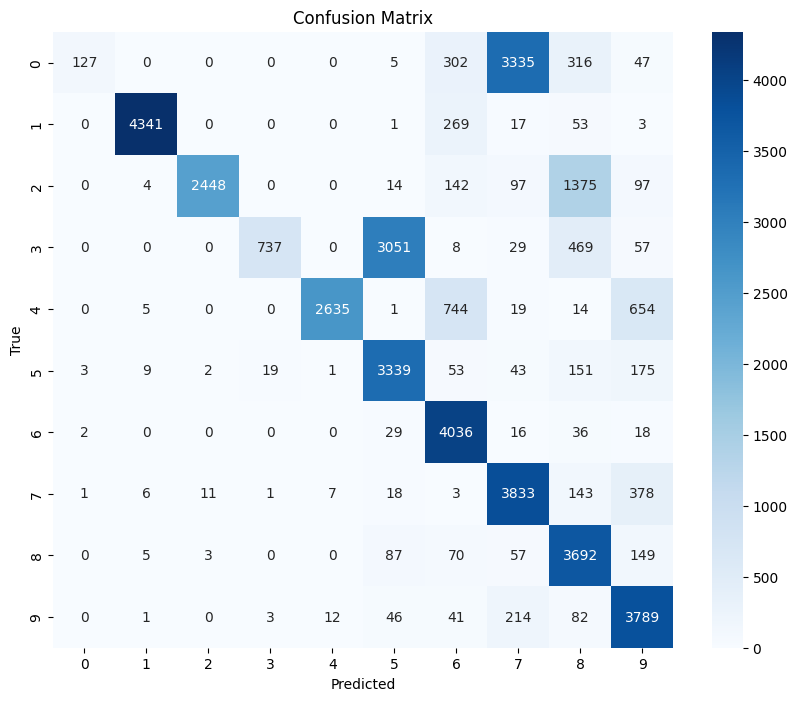

[[ 127    0    0    0    0    5  302 3335  316   47]
 [   0 4341    0    0    0    1  269   17   53    3]
 [   0    4 2448    0    0   14  142   97 1375   97]
 [   0    0    0  737    0 3051    8   29  469   57]
 [   0    5    0    0 2635    1  744   19   14  654]
 [   3    9    2   19    1 3339   53   43  151  175]
 [   2    0    0    0    0   29 4036   16   36   18]
 [   1    6   11    1    7   18    3 3833  143  378]
 [   0    5    3    0    0   87   70   57 3692  149]
 [   0    1    0    3   12   46   41  214   82 3789]]


In [49]:
inference_on_model(model,combined_data_loader,10)

In [61]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

# Define a simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2, 2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2, 2)
        x = x.view(x.size(0), -1)  # Flatten
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def train_model(model, data_loader, criterion, optimizer, epochs, device):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        with tqdm(total=len(data_loader), desc=f"Epoch {epoch + 1}/{epochs}", unit="batch") as pbar:
            for X_batch, y_batch in data_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                optimizer.zero_grad()
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
                pbar.set_postfix(loss=total_loss / (pbar.n + 1))
                pbar.update(1)


# Training function with progress bar
def train_model_with_kd(student, teacher, data_loader, optimizer, criterion_ce, criterion_kd, alpha, temperature, epochs, device):
    student.train()
    teacher.eval()
    for epoch in range(epochs):
        total_loss = 0
        with tqdm(total=len(data_loader), desc=f"Epoch {epoch + 1}/{epochs}", unit="batch") as pbar:
            for X_batch, y_batch in data_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)

                optimizer.zero_grad()

                # Student predictions
                student_outputs = student(X_batch)

                # Teacher predictions (detach to avoid backpropagation through the teacher)
                with torch.no_grad():
                    teacher_outputs = teacher(X_batch)

                # KD Loss
                kd_loss = criterion_kd(
                    nn.functional.log_softmax(student_outputs / temperature, dim=1),
                    nn.functional.softmax(teacher_outputs / temperature, dim=1)
                ) * (temperature ** 2)

                # Cross-Entropy Loss
                ce_loss = criterion_ce(student_outputs, y_batch)

                # Combined Loss
                loss = alpha * kd_loss + (1 - alpha) * (ce_loss * 2)
                loss.backward()
                optimizer.step()

                total_loss += loss.item()
                pbar.set_postfix(loss=total_loss / (pbar.n + 1))
                pbar.update(1)

# Evaluation function
def evaluate_model(model, data_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)
    return correct / total

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Create dataloaders
batch_size = 64
task1_loader = DataLoader(task1_data, batch_size=batch_size, shuffle=True)
task2_loader = DataLoader(task2_data, batch_size=batch_size, shuffle=True)
combined_data_loader = DataLoader(data, batch_size=batch_size, shuffle=False)

# Initialize models
num_classes = 10
teacher_model = SimpleCNN(num_classes=num_classes).to(device)
student_model = SimpleCNN(num_classes=num_classes).to(device)

# Losses and optimizer
criterion_ce = nn.CrossEntropyLoss()
criterion_kd = nn.KLDivLoss(reduction='batchmean')
optimizer_teacher = optim.Adam(teacher_model.parameters(), lr=0.001)
optimizer_student = optim.Adam(student_model.parameters(), lr=0.0005)

# Train teacher on Task 1
print("Training Teacher Model on Task 1...")
train_model(teacher_model, task1_loader, criterion_ce, optimizer_teacher, epochs=5, device=device)
accuracy_task1 = evaluate_model(teacher_model, task1_loader, device)
print(f"Teacher Model Accuracy on Task 1: {accuracy_task1:.2f}")

# Fine-tune student on Task 2 with KD
print("Fine-tuning Student Model on Task 2 using KD...")
alpha = 0.5  # Balance between KD loss and CE loss
temperature = 3.0  # Temperature for KD
train_model_with_kd(
    student=student_model,
    teacher=teacher_model,
    data_loader=task2_loader,
    optimizer=optimizer_student,
    criterion_ce=criterion_ce,
    criterion_kd=criterion_kd,
    alpha=alpha,
    temperature=temperature,
    epochs=5,
    device=device
)

# Evaluate student on all classes
accuracy_combined = evaluate_model(student_model, combined_data_loader, device)
print(f"Student Model Final Accuracy on All Classes: {accuracy_combined:.2f}")


Using device: cuda
Training Teacher Model on Task 1...


Epoch 5/5: 100%|██████████| 335/335 [00:02<00:00, 139.55batch/s, loss=0.00983]


Teacher Model Accuracy on Task 1: 1.00
Fine-tuning Student Model on Task 2 using KD...


Epoch 5/5: 100%|██████████| 322/322 [00:02<00:00, 109.74batch/s, loss=2.91]


Student Model Final Accuracy on All Classes: 0.80


Batch 0 Predictions:
Predicted: [1 0 1 4 0 0 7 3 3 3 3 9 1 3 3 1 2 0 7 3 8 6 2 0 2 3 4 4 9 7 8 9 4 4 2 1 3
 1 1 4 3 1 4 4 2 6 3 3 7 4 7 3 1 9 0 2 2 3 4 1 1 8 3 0]
True:      [1 0 1 4 0 0 7 3 5 3 8 9 1 3 3 1 2 0 7 5 8 6 2 0 2 3 6 9 9 7 8 9 4 9 2 1 3
 1 1 4 9 1 4 4 2 6 3 7 7 4 7 5 1 9 0 2 2 3 9 1 1 1 5 0]

Accuracy: 80.07%


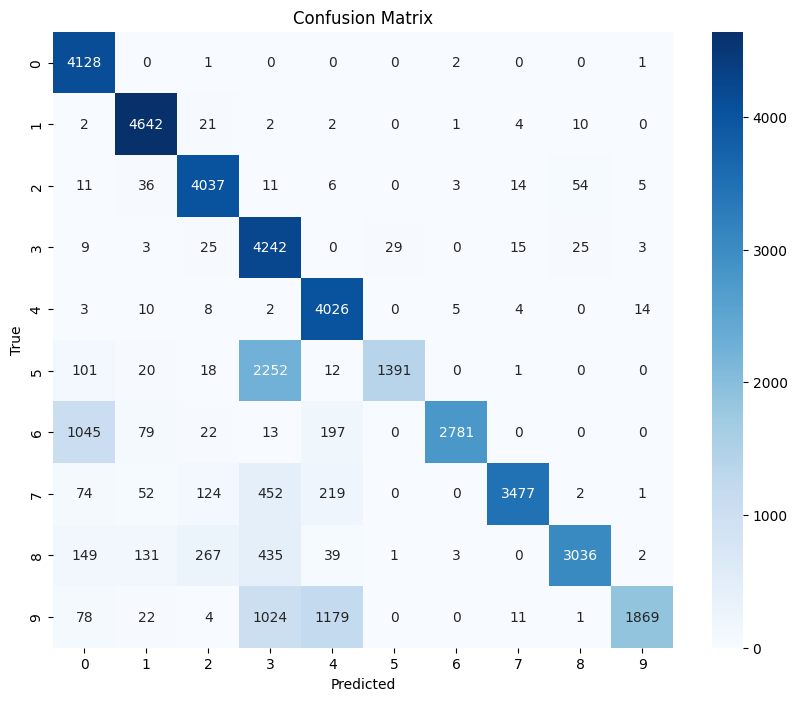

[[4128    0    1    0    0    0    2    0    0    1]
 [   2 4642   21    2    2    0    1    4   10    0]
 [  11   36 4037   11    6    0    3   14   54    5]
 [   9    3   25 4242    0   29    0   15   25    3]
 [   3   10    8    2 4026    0    5    4    0   14]
 [ 101   20   18 2252   12 1391    0    1    0    0]
 [1045   79   22   13  197    0 2781    0    0    0]
 [  74   52  124  452  219    0    0 3477    2    1]
 [ 149  131  267  435   39    1    3    0 3036    2]
 [  78   22    4 1024 1179    0    0   11    1 1869]]


In [62]:
inference_on_model(student_model,combined_data_loader,10)